## Model Training

This notebook contains all of the code used to train the model used in my project. This model makes use of the PyTorch library and the pre-trained Faster R-CNN model provided in the TorchVision library. The structure of the model can be changed to accomadate the different output classes and then finetuned on my training data. The documentation for the Faster R-CNN implementation can be found [here](https://pytorch.org/vision/stable/models/faster_rcnn.html).

The primary components of this model are a region proposal network (RPN), a Fast-RCNN classifier and a backbone. The pytorch stable 1.13.1 and cuda 11.7 versions were used in this environment.

### Imports and Setup

The following imports are needed to run the code in this notebook.

In [39]:
import os
from pathlib import Path
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import ast

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter

import Utils.Training.utils as utils
from Utils.Training.training import *

Before we start, we should check that cuda is installed properly and we can use any GPU we have on our machine with PyTorch.

In [40]:
# Check if cuda is available.
cuda_available = torch.cuda.is_available()

print(f"GPU available: {cuda_available}")

try:
    # Get the cuda device name if available.
    name = torch.cuda.get_device_name(0)
    print(f"GPU name: {name}")
    
except AssertionError:
    print("GPU not found")

GPU available: True
GPU name: NVIDIA GeForce GTX 1050 Ti


### Model inspection

Firstly, I will load the default model, inspect the architecture and ensure that it works as expected. This can be done by using the model to make a prediction on an image from the COCO dataset (which it was trained on). In this way I can better understand how the model should be used and ensure it has the pre-trained weights.

In [44]:
%%capture

# Load the model weights into the model and save as an object. Set the model to evaluation mode so we can inference.
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
model.eval()

We have loaded the weights into the model object and set the model to evaluation mode. Now we can use print on the model to output all of the information regarding the layers and different connections. We can see several different componenets.

+ Transform - the transformations to be applied to an image before it can be passed through the model.
+ backbone (with FPN) - This part of the model is responsible for feature extraction and consists of sequential bottlenecks to create compressed feature representations. The feature pyramid network (FPN) allows for context at different levels by outputing feature maps at multiple levels.
+ Region proposal network (RPN) - Network for proposing regions with possible object of interest that are used during the final stage of detection.
+ Fast R-CNN predictor - Takes the regions and the features maps and returns the detections.

This is the basic overview of our model that can be seen in the below output. This can be finetuned to our specific task with some minor alterations.

In [ ]:
print(model)

Now we can take a sample image from the COCO dataset, which the default weights for the Faster R-CNN model were obtained from. Using this we can see how the model works and also how well it works.

This will involve reading the image, converting it to an appropriate format and passing it to the model to return predictions.

In [ ]:
# Read in a COCO image and convert it to RGB, it was read as RGBA originally.
img = Image.open("D:/DS/DS4/Project/COCO/tennis racket/COCO_test2014_000000000057.jpg").convert("RGB")

In [ ]:
# Check the image.
img

In [ ]:
# Convert the image to a tensor and add an empty dimension so we have [number images x channels x height x width].
tensor_img = T.ToTensor()(img)
tensor_img = tensor_img[None, :]
print(tensor_img.shape)

In [ ]:
# Pass our example image through the model to get the predictions.
# Note: We don't need the GPU here as there is only one image to inference on.
predictions = model(tensor_img)

In [ ]:
# Assess the format of the returned predictions.
predictions

We can see that the predictions are a list of dictionaries for boxes, labels and scores. All of these are of equal length with the element in position 0 in all three being related. So we can take the list of boxes and labels and they will correspond.

We can look up the COCO dataset labels to find out the mapping from class index to class label.

In [ ]:
# Pull the boxes out of the prediction.
boxes = predictions[0]["boxes"]

# These labels were manually entered from the COCO dataset class list.
labels = ["person", "sports ball", "tennis racket", "clock", "sports ball"]

# Take just the first image, which just involves removing the first dimension which corresponds to the number of images.
# which is 1 in our case. Squeeze removes dimensions of length 1.
example = torch.squeeze(tensor_img)

# Convert it to int8. 
example = T.ConvertImageDtype(torch.uint8)(example)

We can make use of the draw_bounding_boxes method to display the boxes and labels on a given image.

In [ ]:
# Use draw_bounding_boxes to overlay the bounding boxes and labels on to the image.
img_with_boxes = draw_bounding_boxes(example, boxes, labels)

Now we can take this image and display it using pyplot.imshow, but we first have to re-order the dimensions.

In [ ]:
# We need to change the ordering as the channels should be the last dimensions for pyplot.
plt.imshow(img_with_boxes.permute(1, 2, 0))

We can see that the model does a good job at finding the object that are present in the COCO dataset classes, meaning the pre-trained weights are good. This is still a good sanity check that the model weights are meaningful and will hopefully be a good starting point for the creation of my model.

### Dataset and Dataloader

Now that we have inspected the model and have a better understanding of the architecture, how to use it and the input and output types we are ready to start fine-tuning it. The first step is to get our data loaded in by creating a PyTorch Dataset and then making use of a Dataloader to load the data in in batches.

The Dataset class below implements the relevant functions to read our Midog data in as a Dataset.

In [41]:
# Create a dataset class inheriting from the Dataset
class MidogDataset(Dataset):
    """
    Class for implementing a dataset for the data for training.
    """
    
    def __init__(self, root, transforms=None):
        """
        root - Path to the directory storing the data
        transforms - transform method to be applied to the data
        """
        
        # Store the root and transforms as class variables.
        self.root = root
        self.transforms = transforms
        
        # load all image files, sorting them to ensure that they are aligned.
        # Save the images into an instance variable.
        self.imgs = list(sorted(os.listdir(Path(root, "data"))))
        
        # Open the training json and load in the data.
        with open(os.path.join(root, "training.json")) as t:   
            training_data = json.load(t)
        
        # Store the data into an instance variable.
        self.data = training_data["images"]

    def __getitem__(self, idx):
        """
        Returns the data for a given index
        
        idx - The index of the data item to be returned
        """
        
        # Get the image path and load the image into memory.
        img_path = Path(self.root, "data", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        # Parse the image path to get the image and tild id.
        image_id, tile_id = self.imgs[idx].split(".")[0].split("_")

        # Get the tile info for the given image and tile id.
        tile_info = self.get_tile_info(image_id, tile_id)

        # Extract the bounding boxes from the tile annotations.
        boxes = []
        for anno in tile_info["annotations"]:
            left, bottom, right, top = anno["bounding_box"].values()
            
            boxes.append([left, bottom, right, top])
        
        # Get the number of objects so we can create the labels.
        num_objs = len(boxes)
        
        # There is only one class, mitotic figure, so all labels are 1.
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # Convert the boxes to a tensor of int32.
        # Note: int 16 is enough to hold the information we have but the model expects the targets in int32 format.
        boxes = torch.as_tensor(boxes, dtype=torch.int32)

        # Create the target dictionary to be returned for a data item.
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["tile_id"] = tile_id
    

        # If there are any transforms defined we can carry them out here.
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        # The number of data items we have the length of our list of image paths.
        # We could have used the individual annotations as a unit of data but this adds additional complexity and 
        # model training is not the primary objective of this project.
        return len(self.imgs)

    def get_tile_info(self, image_id, tile_id):
        """
        Return the dictionary that contains information relating to the given image and tile id.
        
        image_id - The int id of the image we want the data for.
        tile_id - The int id of the tile we want the data for.
        """
        
        # Get the dictionary with information on the given image.
        image_info = next((image for image in self.data if image["image_id"] == int(image_id)), None)
        
        # Within this image dictionary, get the dictionary that relates to the given tile id.
        tile_info = next((tile for tile in image_info["tiles"] if tile["tile_id"] == int(tile_id)), None)
        
        return tile_info

In [42]:
# Define a transformation for the dataset so can have the image as a tensor for use with the model.
def transforms(img, target):
    return T.ToTensor()(img), target

With our dataset defined, we can now create a dataset object by giving the path to the directory containing the training images and json. Then we can use a DataLoader to iterate through the data and return batches of a specified size.

In [43]:
# Create a Dataset object with the given root path to the training data and a defined transformation.
midog = MidogDataset("D:/DS/DS4/Project/Training_mitotic_figures", transforms)

In [45]:
# Create a DataLoader with the dataset with a batch size of 2, no shuffling and use a custom defined collate_fn to batch
# the output as desired.
data_loader = torch.utils.data.DataLoader(midog, batch_size=2, shuffle=False, collate_fn=utils.collate_fn)

In [46]:
# Create an iterator from the DataLoader and take the next item from the iterator.
images, target = next(iter(data_loader))

Using this batch of images from the dataset we can compute predictions. The classes returned will be meaningless as the COCO dataset that the model was originally trained on does not contain mitotic figure as a class. It will be interesting to see if the model can detect anything of interest in these images.

In [49]:
# Pass the images to the model, which is in evaluation mode already.
predictions, _ = model(images)

In [50]:
# Pull the boxes out of the prediction.
boxes = predictions[0]["boxes"]

# Concatenate the prediction boxes and the ground truth boxes so we can view both.
final_boxes = torch.cat([boxes, target[0]["boxes"]])

# Create a list of labels using the length of the predictions and ground truths.
labels = (["pred"] * len(boxes)) + (["gt"] * len(target[0]["boxes"]))

# Take just the first image.
# Note: We can't use squeeze as the first dimension is not 1 this time, but 2 as our batch size is 2.
example = images[0,:]

# Convert the image to int8.
example = T.ConvertImageDtype(torch.uint8)(example) # Convert it to int8 

In [51]:
# Use draw_bounding_boxes to overlay the bounding boxes and labels on to the image.
img_with_boxes = draw_bounding_boxes(example, final_boxes, labels)

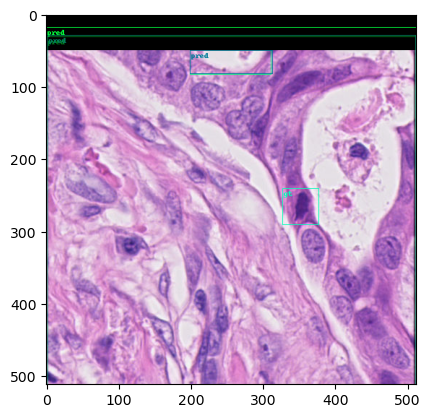

In [52]:
# We need to change the ordering as the channels should be the last dimensions for pyplot.
plt.imshow(img_with_boxes.permute(1, 2, 0))

Unfortunately, there does not seem to be any meaningful predictions being made by the model with default weights. This is to be expected as the task is in a different domain. Once we have trained the model on our data we will see much more reasonable predictions.

### Model Alteration

Now we need to make some alterations to our model before we train it. We need to change the output number of classes, so we need to create a new predictor that takes the feature maps and predicts the class and bounding box for an object. This can be done as seen below.

In [5]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (mitotic figure) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Now our model is ready to be fine-tuned.

### Data sanity check

Before training I will do a quick sanity check of the data to ensure it is all as it should be.

It turns out that there was a bug in my bounding box generation process that didn't account for tile difference when a bounding box was negative i.e. on the padding to the left or under the original tile. This has been fixed and now my sanity checks are as expected. Helping to preserve my sanity.

In [ ]:
# Use our dataset and defined transformations.
dataset = MidogDataset("D:/DS/DS4/Project/Training_mitotic_figures", transforms)

# Initiate the DataLoader.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=False, collate_fn=utils.collate_fn)

# For every image and target in the iterator
for images, targets in data_loader:
    try:
        # Check that no values are outside of the boudanries (412 x 412 original and 50 pixel padding all around, so 512 x 512)
        assert(max([t["boxes"].numpy().max() for t in targets]) <= 512)
        assert(min([t["boxes"].numpy().min() for t in targets]) >= 0)

        # Stack all of the boxes vertically.
        boxes = np.vstack([t["boxes"].numpy() for t in targets])

        # Check that the x1 < x2 for all of these boxes.
        assert(np.all(boxes[:,0] < boxes[:,2]) == True)

        # Check that y1 < y2 for all of these boxes.
        assert(np.all(boxes[:,1] < boxes[:,3]) == True)
    
    # If we encounter an AssertionError, print the dictionary of annotations that caused it.
    except AssertionError:
        print(targets)

### Model training

The process of training our model consists of multiple steps.

Firstly we create our dataset and split it into a train and test set. We can make use of torch.manual_seed to ensure that the random premutation we get for the indices stays the same on every run. There are 7549 training images, some of these may have more than 1 example on them. Let us take ~10% of the data for testing, which is 750 tiles for testing (375 batches of 2 images).

Now that we have our data, we need to consider the loss. This is returned in the form of a classification and regression loss for the RPN and the R-CNN. These can be summed to get the total loss which can be used to compute the optimization steps.

We will make use of the Adam optimizer, which makes use of both Momentum and root mean square propagation to converge faster.

This covers our main training loop that updates our weights. After every epoch we would like to run the model on our test set and look at some metrics. We will make use of TorchMetrics to compute the mAP (MeanAveragePrecision) for the test set. In addition, looking at the test loss will allow us to know when we should stop training. In this way, we can avoid overfitting the training data.

TorchMetrics is easy to use and involves passing the ground truths and predictions to the object created from the MeanAveragePrecision class. Returning the test loss is a different story. The classes for the components of the model in Torchvision don't return the loss when in evaluation. To remedy this, I altered the logic in these files to ensure that if the ground truths are provided the loss is returned. This preseves the previous functionality while allowing me to return the loss.

The below code is the original final output from the GeneralizedRCNN class:

``` 
def eager_outputs(self, losses, detections):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Union[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections
```

This is what I changed it to:
``` 
def eager_outputs(self, losses, detections):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Union[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        elif losses:
            return losses, detections

        return detections
``` 

Changes also had to be made to the logic in the components of the GeneralizedRCNN, namely the classes in roi_heads.py and rpn.py. These altered files will be included in the repositiory so the test loss can be computed during the following training.

With all of this, we are ready to train our model.

In [ ]:
# Create a TensorBoard SummaryWriter so we can write metrics to the TensorBoard logs for monitoring.
# Note: This was not useful as sessions don't seem to work well when the SummaryWriter is initialized again, when training at
# another point in time.
writer = SummaryWriter('D:/DS/DS4/Project/tensorboard_logs/midog_training')

Now we can load our dataset and pass it to our train method. This method and other methods that are called within train can be found under Training in the Utils folder of the projecy repo.

The model can be trained from scratch, or a checkpoint file from torch.save can be passed that contains the model state_dict, the optimizer state_dict and the current epoch.

Using all of the data takes roughly 1 hour and 30 minutes to train one epoch.

In [ ]:
dataset = MidogDataset("D:/DS/DS4/Project/Training_mitotic_figures", transforms)

In [ ]:
# Training from scratch, no checkpoint is given.
train(model, dataset, 10, "D:/DS/DS4/Project/model_saves", writer)

If we would like to continue training from a checkpoint we can use the below code and read in the checkpoint and pass it to the train function.

In [ ]:
# Training from a checkpoint, which is passed as the last parameter to train.
checkpoint = torch.load("D:/DS/DS4/Project/model_saves/2023_03_02_16_35_46_8.pth", map_location=lambda storage, loc: storage)
train(model, dataset, 10, "D:/DS/DS4/Project/model_saves", writer, checkpoint)

### Training overview

Once we have trained our model, we can look at the training and test loss to determine the best model for us to use. To do this, we can read in the metrics file and extract the train and test loss. This will only involve reading the text in and parsing it to extract these values.

In [ ]:
# Open the metrics file
with open("D:/DS/DS4/Project/model_saves/final_metrics.txt") as metrics:
    data = metrics.read()

# Extract the lines relating to loss
loss_entries = data.split("\n")[0::3]

# Split the line on " loss: "
split_losses = [epoch.split(" loss: ") for epoch in loss_entries]

# Variables for storing the losses
training_loss, test_loss = [], []

for loss_list in split_losses:
    # Append the training loss from the second element after splitting the whitespace.
    training_loss.append(float(loss_list[1].split(" ")[0]))
    
    # Take the last element as the test loss.
    test_loss.append(float(loss_list[2]))

# This is a list of strings that represent the MeanAveragePrecision dictionary.
# So we will need to convert this back to a dictionary
metrics = [metric for metric in data.split("\n")[1::3]]# [literal_eval(metric) for metric in data.split("\n")[1::3]]

In [ ]:
plt.plot(training_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

We can see that there is no drastic changes in the test loss, so we could continue training. Though, there will be marginal improvement at the cost of lots of computational power. So I believe this training is sufficient for our usecase and we can take the model at epoch 11, which has the lowest test loss and best COCO mAP metrics.

In order to extract the mAP metrics, we can either view the raw string, or use eval to take the string as Python code. There is one small issue with this approach considering our format. The values are stored in tensors, denoted by the tensor(value). This is not a defined funtion in Python, so we can use an adhoc solution which is to define such a function that returns the value passed.

In [ ]:
# Example of the metrics string.
metrics[0]

In [ ]:
# Dummy tensor function to return the value passed when using eval on the metric string.
def tensor(value):
    return value

# Let us take the metrics at epoch 11.
metric_dict = eval(metrics[11])

In [ ]:
metric_dict

We can see that the metrics are decent and the model has a reasonable mAP considering there is only one class. There may be changes that could be made to the learning rate during training, but this is not significant for my usecase.

### Review trained model predictions

We can now load the model and see how well the predictions look visually for images from the test set.

In [60]:
# Load in the best model by specifying the path to the save.
checkpoint = torch.load("D:/DS/DS4/Project/model_saves/2023_03_04_17_22_33_11.pth")

In [61]:
# Take the model that we have already initialized and load the state_dict into it.
model.load_state_dict(checkpoint["model_state_dict"])

# Set it to evaluation mode.
model.eval()

RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([2, 1024]) from checkpoint, the shape in current model is torch.Size([91, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([91]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([8, 1024]) from checkpoint, the shape in current model is torch.Size([364, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([364]).

In [ ]:
# Use our dataset and defined transformations.
dataset = MidogDataset("D:/DS/DS4/Project/Training_mitotic_figures", transforms)

# Split the dataset into the train and test set, using the same random seed to ensure the same split.
torch.manual_seed(42)
indices = torch.randperm(len(dataset)).tolist()
dataset_test = torch.utils.data.Subset(dataset, indices[-750:])

# Create the DataLoader for the test dataset.
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)

# Create an iterator from the DataLoader.
iter_data = iter(data_loader_test)

In [ ]:
# Get the next batch from the DataLoader
images, targets = next(iter_data)

# Use the GPU if it is available.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move both the model and the data to the device, ideally the GPU.
model.to(device)
images = images.to(device)
targets = [{k: v.to(device) for k, v in t.items() if k in ["boxes", "labels"]} for t in targets]

# Don't calculate gradients as we aren't updating the weights and this will save memory.
with torch.no_grad():
    predictions, class_logits = model(images)

print(class_logits)

 # Pull the boxes out of the prediction.
boxes = predictions[0]["boxes"]

# Concatenate the prediction and ground truth bounding boxes.
final_boxes = torch.cat([boxes, targets[0]["boxes"]])

# Create a list of labels using the length of the list of predictions and list of ground truths.
labels = (["pred"] * len(boxes)) + (["gt"] * len(targets[0]["boxes"]))

# Reduce the dimension to just channel x height x width as we have only one image in the batch and want to display it.
example = torch.squeeze(images)

# Convert the image to int8
example = T.ConvertImageDtype(torch.uint8)(example)


img_with_boxes = draw_bounding_boxes(example, final_boxes, labels)

# We need to change the ordering as the channels should be the last dimensions for pyplot.
plt.imshow(img_with_boxes.permute(1, 2, 0))

We can see from running the last cell several times that the ground truth is almost always detected by the model and typically with a high confidence in the prediction. This shows to me that the model has learnt some of the intricacies of what makes mitotic figures stand out from other cells or artefacts within a tile from a whole slide image.

### Extracting snippets of annotations for concepts

For generating concepts from the mitotic figures I will need to extract the annotations in the bounding boxes so visual concepts can be discovered more easily. If I don't carry this out, concepts relating to the visual features of the entire tile will be generated.

In [58]:
# Load the dataset
dataset = MidogDataset("D:/DS/DS4/Project/Training_mitotic_figures")

# Set the output path and create a directory
output_path = Path("D:/DS/DS4/Project/Mitotic_figures")
output_path.mkdir(exist_ok=True, parents=True)

# Iterate over the images and targets
for image, target in tqdm(dataset, total=len(dataset)):
    
    # For every bounding box in the annotation, create a snippet.
    for i, box in enumerate(target["boxes"]):
        
        # Extract the box coordinates 
        left, bottom, right, top = box
        left, bottom, right, top = left.item(), bottom.item(), right.item(), top.item()
        snippet = image.crop(box=(left, bottom, right, top))
        
        # Get the identifiers
        image_id = target["image_id"]
        tile_id = target["tile_id"]
        
        # Save the snippet using a unique name consisting of the image_id, tile_id and box number.
        snippet.save(output_path / f"{image_id}_{tile_id}_{i}.png", format="PNG")

100%|██████████████████████████████████████████████████████████████████████████████| 7549/7549 [10:57<00:00, 11.49it/s]


### Testing extraction of the activations and gradients for generating and testing CAVs

The process of creating concepts vectors involves the use of activations from the 

[{'boxes': tensor([[359.5612, 430.6874, 409.4513, 481.8993]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0627], device='cuda:0', grad_fn=<IndexBackward0>)}]


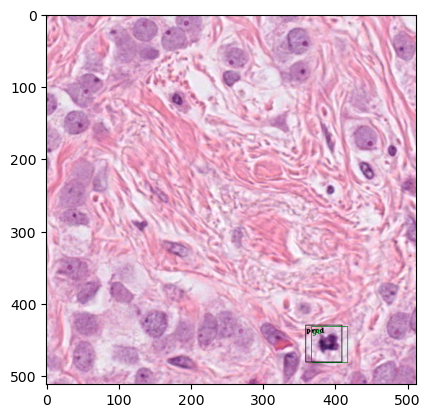

In [62]:
# Get the next batch from the DataLoader
images, targets = next(iter_data)

# Use the GPU if it is available.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move both the model and the data to the device, ideally the GPU.
model.to(device)
images = images.to(device)
targets = [{k: v.to(device) for k, v in t.items() if k in ["boxes", "labels"]} for t in targets]

# Don't calculate gradients as we aren't updating the weights and this will save memory.
predictions, class_logits = model(images)
print(predictions)

 # Pull the boxes out of the prediction.
boxes = predictions[0]["boxes"]

# Concatenate the prediction and ground truth bounding boxes.
final_boxes = torch.cat([boxes, targets[0]["boxes"]])

# Create a list of labels using the length of the list of predictions and list of ground truths.
labels = (["pred"] * len(boxes)) + (["gt"] * len(targets[0]["boxes"]))

# Reduce the dimension to just channel x height x width as we have only one image in the batch and want to display it.
example = torch.squeeze(images)

# Convert the image to int8
example = T.ConvertImageDtype(torch.uint8)(example)


img_with_boxes = draw_bounding_boxes(example, final_boxes, labels)

# We need to change the ordering as the channels should be the last dimensions for pyplot.
plt.imshow(img_with_boxes.permute(1, 2, 0))

In [12]:
class_logits[:,1].backward()

In [ ]:
class_logits[:, 1][0].backward()

In [ ]:
[p for p in model.named_parameters()]

In [63]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

In [64]:
bottlenecks = ['body.layer1.2.conv1', 'body.layer2.3.conv1', 'body.layer3.5.conv1', 'body.layer4.2.conv1']
fe = create_feature_extractor(model.backbone, bottlenecks)
fe.to(device)

BackboneWithFPN(
  (body): Module(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Module(
      (0): Module(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Module(
          (0): Co

In [65]:
activations = fe(images)

In [66]:
activation = activations['body.layer2.3.conv1']
# activation.register_hook(self.save_gradient)
logit = class_logits[:, 1]
logit.backward(torch.ones_like(logit), retain_graph=True)
# gradients = grad(logit, activation, retain_graph=True)[0]
# gradients = gradients.cpu().detach().numpy()
# gradients = self.gradients.cpu().detach().numpy()
# return gradients

In [ ]:
class_logit = class_logits[[1,12],:]#.backward()

In [ ]:
class_logit.backward()

In [67]:
np.unique(model.roi_heads.box_predictor.cls_score.weight.grad.cpu().detach().numpy())

array([0.00000000e+00, 5.21313017e-39, 3.49723450e-06, 4.68144117e-06,
       2.09212994e-05, 2.95753780e-05, 5.89963238e-05, 8.70716613e-05,
       8.70738149e-05, 1.03592189e-04, 1.13050992e-04, 1.19968092e-04,
       1.56715920e-04, 1.58886367e-04, 1.74555156e-04, 1.75342298e-04,
       1.79509807e-04, 1.82319927e-04, 2.12589715e-04, 2.61122594e-04,
       2.70409480e-04, 2.85023940e-04, 2.87275005e-04, 3.02132394e-04,
       3.22220847e-04, 3.33864067e-04, 3.51022987e-04, 3.62035760e-04,
       3.69923917e-04, 3.73906398e-04, 4.09373082e-04, 4.26274579e-04,
       4.44729871e-04, 4.69808612e-04, 4.76482470e-04, 4.76668181e-04,
       4.85185097e-04, 5.03470481e-04, 5.20596514e-04, 5.33886894e-04,
       5.38434950e-04, 5.44418523e-04, 5.73438359e-04, 5.79699990e-04,
       5.87818678e-04, 5.91407239e-04, 6.00858824e-04, 6.06422836e-04,
       6.15171331e-04, 6.96973526e-04, 7.26073456e-04, 7.26127648e-04,
       7.38895673e-04, 7.99769536e-04, 8.14853818e-04, 8.26863339e-04,
      

In [69]:
model.zero_grad()

In [70]:
np.unique(model.backbone.body.layer2[3].conv1.weight.grad.cpu().detach().numpy())

array([0.], dtype=float32)

In [ ]:
body.layer2.3.conv1

In [ ]:
gradients = torch.autograd.grad(class_logits[:, 1][0], activation, retain_graph=True)

In [ ]:
import torch
import numpy as np


class ModelWrapper(object):
    def __init__(self, model, bottleneck_layers, names):
        self.model = model
        self.intermediate_activations = {}

        def save_activation(name):
            '''create specific hook by module name'''

            def hook(module, input, output):
                self.intermediate_activations[name] = output

            return hook

        for layer, name in zip(bottleneck_layers, names):
            # register the hook
            layer.register_forward_hook(save_activation(name))

    def save_gradient(self, grad):
        self.gradients = grad

    def generate_gradients(self, c, layer_name):
        activation = self.intermediate_activations[layer_name]
        activation.register_hook(self.save_gradient)
        _, logit = self.output[:, c]
        logit.backward(torch.ones_like(logit), retain_graph=True)
        gradients = self.gradients.cpu().detach().numpy()
        return gradients

    def eval(self):
        self.model.eval()

    def train(self):
        self.model.train()

    def to(self, device):
        self.model = self.model.to(device)
        return self

    def __call__(self, x):
        self.output = self.model(x)
        return self.output